# This is a notebook to for Stackoverflow Preprocessing

> Steps: 
1. Explore the data (length of posts, words, ...)

# Initialize the connection

In [35]:
import os
from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='key.json'
bigquery_client = bigquery.Client(project='bigquery-public-data') 
bigquery_client = bigquery.Client() #stackoverflow

# Query

In [37]:
QUERY = """
Select id, title, body, tags
FROM `bigquery-public-data.stackoverflow.posts_questions`
WHERE CAST(creation_date as DATE) > '2021-01-20'
    """

query_job = bigquery_client.query(QUERY)
data = query_job.to_dataframe()
print(data)

              id                                              title  \
0       66138537          DataExplorer with at least two given tags   
1       66229417  Using a single object (dataframe) across multi...   
2       66288134  Can we use rpl and leach routing protocol toge...   
3       66293452  How to clone dynamic component with button click?   
4       66317042  Can Firebase Admin SDK be used in Angular Karm...   
...          ...                                                ...   
244963  66199108   Quad Core ARM 11MP for Nintendo 3DS CPU clocking   
244964  66160719  Does glibc (GNU C Library) provide a way to ob...   
244965  66368662  document.forms[1] submits document.forms[0]. Why?   
244966  66315214  How can I export and save data in csv format o...   
244967  66274948  Why am I seeing more RFO (Read For Ownership) ...   

                                                     body  \
0       <p>I would to fetch data from Data Explorer, I...   
1       <p>I am hosting a

# IMPORT THE LIBRARIES FOR PREPROCESSING

In [47]:
!pip install gensim
!pip install python-Levenshtein
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import gensim
import regex as re

# TOKENIZE, REMOVE STOPWORDS

In [39]:
body = data['body']

def tokenize_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        
tokenized_words = list(tokenize_to_words(body))
print(tokenized_words[0:3])

[['would', 'to', 'fetch', 'data', 'from', 'data', 'explorer', 'wrote', 'my', 'code', 'below', 'but', 'what', 'is', 'wrong', 'exactly', 'with', 'this', 'condition', 'the', 'condition', 'is', 'data', 'including', 'at', 'least', 'these', 'two', 'given', 'tags', 'as', 'input', 'so', 'it', 'doesn', 'matter', 'what', 'are', 'the', 'others', 'if', 'exists', 'pre', 'code', 'declare', 'tagstring', 'nvarchar', 'tagname', 'string', 'declare', 'tagstring', 'nvarchar', 'tagname', 'string', 'select', 'top', 'topfetched', 'id', 'as', 'qid', 'creationdate', 'as', 'qcreationdate', 'score', 'as', 'qscore', 'viewcount', 'as', 'qviewcount', 'favoritecount', 'as', 'qfavoritecount', 'commentcount', 'as', 'qcommentcount', 'answercount', 'as', 'qanswercount', 'as', 'lasteditdate', 'as', 'qlasteditdate', 'as', 'title', 'as', 'qtitle', 'body', 'as', 'qbody', 'id', 'as', 'aid', 'creationdate', 'as', 'acreationdate', 'score', 'as', 'ascore', 'commentcount', 'as', 'acommentcount', 'lasteditdate', 'as', 'alasteditd

# LENGTH OF BODY

In [40]:
print("minimum body length: ", body.str.len().min())
print("maximum body length: ", body.str.len().max())

minimum body length:  37
maximum body length:  60993


# REMOVE STOP WORDS

In [41]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fenypatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

removed_stop = remove_stopwords(tokenized_words)
print(removed_stop[0:3])

[['would', 'fetch', 'data', 'data', 'explorer', 'wrote', 'code', 'wrong', 'exactly', 'condition', 'condition', 'data', 'including', 'least', 'two', 'given', 'tags', 'input', 'matter', 'others', 'exists', 'pre', 'code', 'declare', 'tagstring', 'nvarchar', 'tagname', 'string', 'declare', 'tagstring', 'nvarchar', 'tagname', 'string', 'select', 'top', 'topfetched', 'id', 'qid', 'creationdate', 'qcreationdate', 'score', 'qscore', 'viewcount', 'qviewcount', 'favoritecount', 'qfavoritecount', 'commentcount', 'qcommentcount', 'answercount', 'qanswercount', 'lasteditdate', 'qlasteditdate', 'title', 'qtitle', 'body', 'qbody', 'id', 'aid', 'creationdate', 'acreationdate', 'score', 'ascore', 'commentcount', 'acommentcount', 'lasteditdate', 'alasteditdate', 'body', 'abody', 'posts', 'join', 'posts', 'id', 'inner', 'join', 'posttags', 'question_tags', 'question_tags', 'postid', 'id', 'inner', 'join', 'tags', 'question_tags', 'tagid', 'tags', 'id', 'id', 'gt', 'tags', 'tagname', 'tagstring', 'tagstri

# STEMMING

In [43]:
stemmer = SnowballStemmer('english')
stemmed = [[stemmer.stem(word) for word in t_list] for t_list in removed_stop]
print(stemmed[0:10])

[['would', 'fetch', 'data', 'data', 'explor', 'wrote', 'code', 'wrong', 'exact', 'condit', 'condit', 'data', 'includ', 'least', 'two', 'given', 'tag', 'input', 'matter', 'other', 'exist', 'pre', 'code', 'declar', 'tagstr', 'nvarchar', 'tagnam', 'string', 'declar', 'tagstr', 'nvarchar', 'tagnam', 'string', 'select', 'top', 'topfetch', 'id', 'qid', 'creationd', 'qcreationd', 'score', 'qscore', 'viewcount', 'qviewcount', 'favoritecount', 'qfavoritecount', 'commentcount', 'qcommentcount', 'answercount', 'qanswercount', 'lasteditd', 'qlasteditd', 'titl', 'qtitl', 'bodi', 'qbodi', 'id', 'aid', 'creationd', 'acreationd', 'score', 'ascor', 'commentcount', 'acommentcount', 'lasteditd', 'alasteditd', 'bodi', 'abodi', 'post', 'join', 'post', 'id', 'inner', 'join', 'posttag', 'question_tag', 'question_tag', 'postid', 'id', 'inner', 'join', 'tag', 'question_tag', 'tagid', 'tag', 'id', 'id', 'gt', 'tag', 'tagnam', 'tagstr', 'tagstr', 'order', 'viewcount', 'desc', 'code', 'pre'], ['host', 'server', '

# ADD PROCESSED WORDS TO DATAFRAME

In [44]:
tokenized_frame = pd.DataFrame(columns = ['tokenized'])
j = 0
for i in removed_stop:
    tokenized_frame.loc[j, 'tokenized'] = i
    j = j + 1

In [45]:
final_data = pd.concat([data, tokenized_frame], axis=1)
print(final_data.head())

         id                                              title  \
0  66138537          DataExplorer with at least two given tags   
1  66229417  Using a single object (dataframe) across multi...   
2  66288134  Can we use rpl and leach routing protocol toge...   
3  66293452  How to clone dynamic component with button click?   
4  66317042  Can Firebase Admin SDK be used in Angular Karm...   

                                                body  \
0  <p>I would to fetch data from Data Explorer, I...   
1  <p>I am hosting a server on a private computer...   
2  <p>as I am new to wsn please can anyone tell m...   
3  <p>My client requirement is duplication of exi...   
4  <p>I’ve got an Angular CLI app and am testing ...   

                                      tags  \
0                             dataexplorer   
1                           rstudio-server   
2                                   routes   
3               angular-dynamic-components   
4  angularfire2|angularfire|firebase

In [40]:
final_data.to_csv('preprocessed.csv')

# TAG EXPLORATION

In [92]:
tags = []
for i, row in final_data.iterrows():
    tags.append(list(row["tags"].split("|")))
final_data["tokenized_tags"] = tags
print(final_data.head())

         id                                              title  \
0  66138537          DataExplorer with at least two given tags   
1  66229417  Using a single object (dataframe) across multi...   
2  66288134  Can we use rpl and leach routing protocol toge...   
3  66293452  How to clone dynamic component with button click?   
4  66317042  Can Firebase Admin SDK be used in Angular Karm...   

                                                body  \
0  <p>I would to fetch data from Data Explorer, I...   
1  <p>I am hosting a server on a private computer...   
2  <p>as I am new to wsn please can anyone tell m...   
3  <p>My client requirement is duplication of exi...   
4  <p>I’ve got an Angular CLI app and am testing ...   

                                      tags  \
0                             dataexplorer   
1                           rstudio-server   
2                                   routes   
3               angular-dynamic-components   
4  angularfire2|angularfire|firebase

In [93]:
tag_count_dict = {}
for sublist in tags:
    for i in sublist:
        if i not in tag_count_dict.keys():
            tag_count_dict[i] = 0
        tag_count_dict[i] += 1

In [94]:
max_key = max(tag_count_dict, key=tag_count_dict.get)
print(max_key, tag_count_dict[max_key])

python 37482


['python', 'javascript', 'java', 'reactjs', 'c#', 'html', 'android', 'php', 'node.js', 'python-3.x', 'r', 'css', 'c++', 'pandas', 'sql', 'flutter', 'angular', 'django', 'typescript', 'arrays', 'mysql', 'swift', 'c', 'ios', 'jquery']


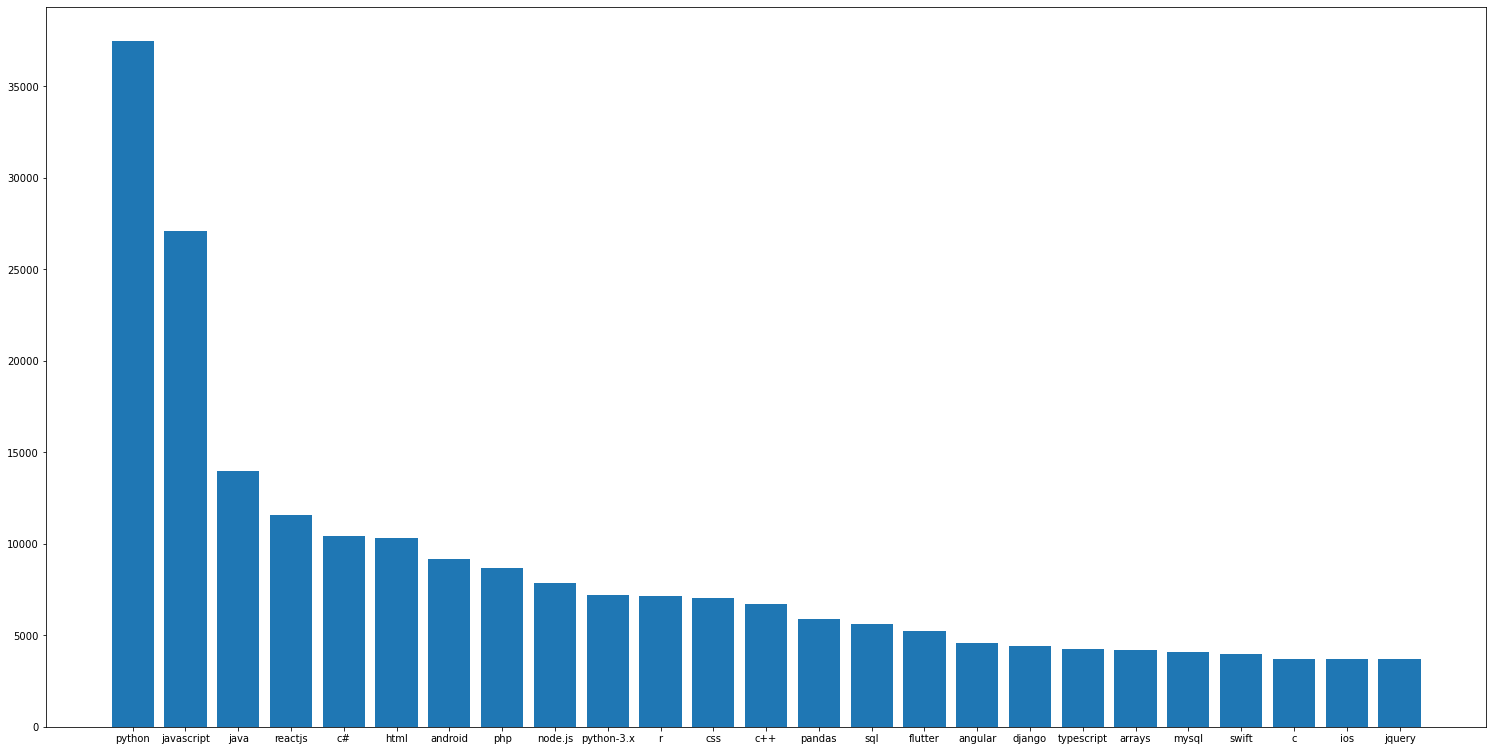

In [110]:
top_10_tags = sorted(tag_count_dict, key = tag_count_dict.get, reverse=True)[:25]
print(top_10_tags)
fig = plt.figure()
plt.rcParams["figure.figsize"] = (30, 20)
ax = fig.add_axes([0,0,1,1])
count = [tag_count_dict[i] for i in top_10_tags]
ax.bar(top_10_tags, count)
plt.show()

# TOTAL TAGS

In [97]:
total_tags = 0
for sublist in tags:
    total_tags += len(sublist)
print(total_tags)

738830
